#### Imports

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.optimize #fmin_cg to train the linear regression

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

## Notes on Selecting Data Sets

In [70]:
#One way to break down our dataset into the three sets is:
    #Training set: 60%
    #Cross validation set: 20%
    #Test set: 20%
#We can now calculate three separate error values for the three different sets using the following method:
    #1. Optimize the parameters in Θ using the training set for each polynomial degree.
    #2. Find the polynomial degree d with the least error using the cross validation set.
    #3. Estimate the generalization error using the test set with the cost of test set 
        #using theta from polynomial with lower error

## Diagnosing Bias vs. Variance

In [71]:
#Really good article on explaining high bias and high variance:
# https://www.quora.com/What-is-high-bias-and-high-variance-in-machine-learning-terminology-in-simplest-terms

# High bias means you can't fit the data well
# High variance means the model doesn't generalize well and can fluctuate wildly
# High bias is underfitting and high variance is overfitting
# Ideally, we need to find a optimal balance between these two

#The training error will tend to decrease as we increase the degree d of the polynomial
#At the same time, the cross validation error will tend to decrease as we increase d up to a point, 
#and then it will increase as d is increased, forming a convex curve.

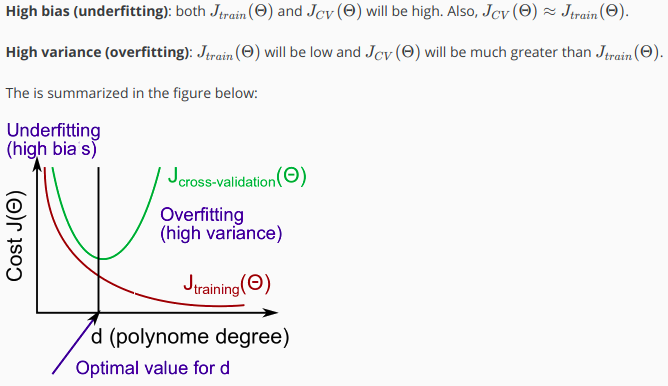

In [74]:
Image("diagnosing_bias_variance2.png", width=600, height=600)

## 1. Regularized Linear Regression

In [8]:
datafile = 'ex5data1.mat'
mat = scipy.io.loadmat( datafile )
#Training set
X, y = mat['X'], mat['y']
#Cross validation set
Xval, yval = mat['Xval'], mat['yval']
#Test set
Xtest, ytest = mat['Xtest'], mat['ytest']
#Insert a column of 1's to all of the X's, as usual
X =     np.insert(X    ,0,1,axis=1)
Xval =  np.insert(Xval ,0,1,axis=1)
Xtest = np.insert(Xtest,0,1,axis=1)

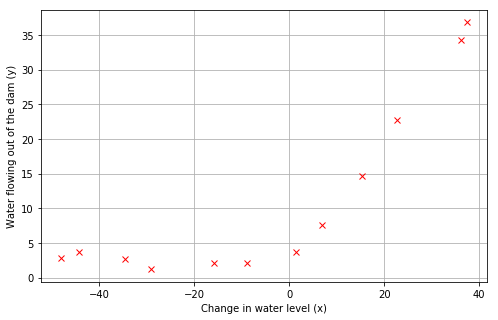

In [11]:
def plot_data():
    plt.figure(figsize=(8,5))
    plt.ylabel('Water flowing out of the dam (y)')
    plt.xlabel('Change in water level (x)')
    plt.plot(X[:,1],y,'rx')
    plt.grid(True)
    
plot_data()

#### Regularized Linear Regression Cost Function

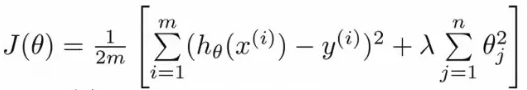

In [12]:
Image("Cost_function_with_regularization1.png", width=400, height=100)

In [13]:
def hypothesis(theta,X):
    return np.dot(X,theta)

# Linear regression cost function is the sum of squarred errors

def cost_function(my_theta,my_X,my_y,my_lambda=0.):
    """
    theta_start is an n- dimensional vector of initial theta guess
    X is matrix with n- columns and m- rows
    y is a matrix with m- rows and 1 column
    """
    m = my_X.shape[0] # shape[], 0 for number of rows, 1 for number of columns
    my_hypothesis = hypothesis(my_theta,my_X).reshape((m,1))
    my_cost = float((1./(2*m)) * np.dot((my_hypothesis-my_y).T,(my_hypothesis-my_y)))
    regterm = (float(my_lambda)/(2*m))*float(my_theta[1:].T.dot(my_theta[1:])) #skip 1st theta for regularization
    return my_cost + regterm

# X.shape = (12,2)
# y.shape = (12,1)
# Xval.shape = (21,2)
# yval.shape = (21,1)
# Xtest.shape = (21,2)
# ytest.shape = (21,1)

In [14]:
# Test cost_function using theta initialized at [1; 1], and lambda = 1,
mytheta = np.array([[1.],[1.]])
cost_function(mytheta,X,y,my_lambda=1.)

303.9931922202643

#### Regularized linear regression gradient

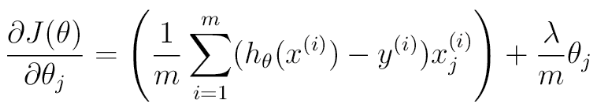

In [16]:
Image("Regularized_gradient_descent1.png", width=400, height=100)

In [17]:
def compute_gradient(my_theta,my_X,my_y,my_lambda=0.):
    my_theta = my_theta.reshape((my_theta.shape[0],1))
    m = my_X.shape[0] #the number of sample data from either the training, cross-validation, or test set
    #grad has same shape as my_theta (2x1)
    my_hypothesis = hypothesis(my_theta,my_X).reshape((m,1))
    grad = (1./float(m))*my_X.T.dot(hypothesis(my_theta,my_X)-my_y)
    regterm = (float(my_lambda)/m)*my_theta
    regterm[0] = 0 #don't regulate bias term
    regterm.reshape((grad.shape[0],1))
    return grad + regterm

#Here's a wrapper for compute_gradient that flattens the output
#This is for the minimization routine that wants everything flattened
def compute_gradient_flattened(my_theta,my_X,my_y,my_lambda=0.):
    return compute_gradient(my_theta,my_X,my_y,my_lambda=0.).flatten()

In [18]:
# computing gradient using thetas initialized at [1; 1]
mytheta = np.array([[1.],[1.]])
compute_gradient(mytheta,X,y,1.)

array([[-15.30301567],
       [598.25074417]])

#### Fitting Linear Regression

In [33]:
def optimize_theta(myTheta_initial, myX, myy, my_lambda=0.,print_output=True):
    fit_theta = scipy.optimize.fmin_cg(cost_function,x0=myTheta_initial,\
                                       fprime=compute_gradient_flattened,\
                                       args=(myX,myy,my_lambda),\
                                       disp=print_output,\
                                       epsilon=1.49e-12,\
                                       maxiter=1000)
    fit_theta = fit_theta.reshape((myTheta_initial.shape[0],1))
    return fit_theta

In [34]:
mytheta = np.array([[1.],[1.]])
fit_theta = optimize_theta(mytheta,X,y,0.)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


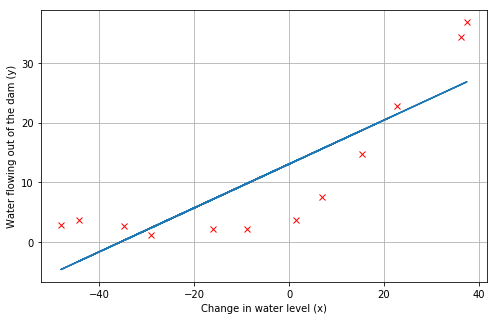

In [35]:
plot_data()
plt.plot(X[:,1],hypothesis(fit_theta,X).flatten())

## 2. Bias-variance

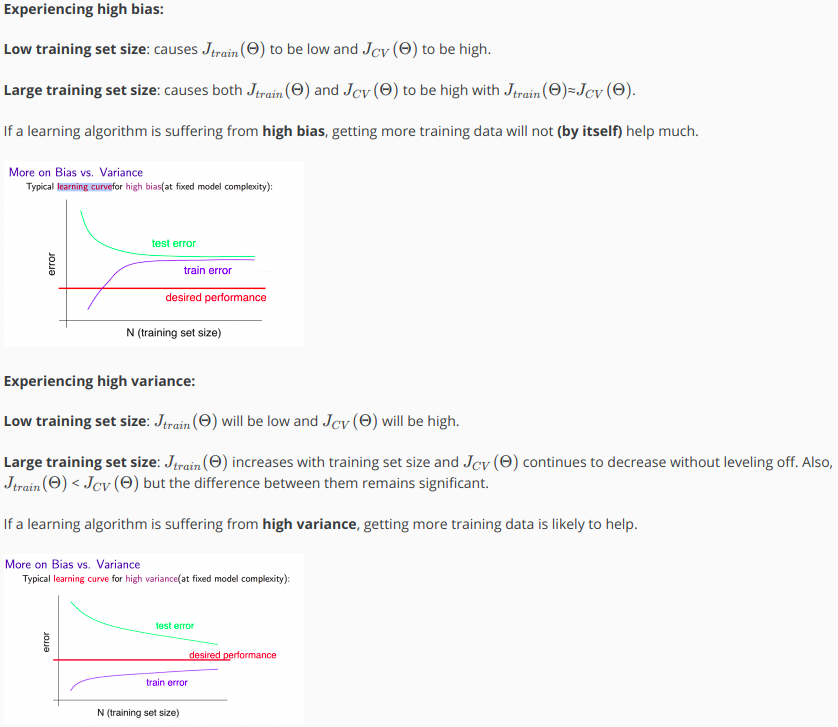

In [41]:
Image("Bias_vs_variance1.png", width=700, height=800)

In [36]:
def plotLearningCurve():
    """
    Loop over first training point, then first 2 training points, then first 3 ...
    and use each training-set-subset to find trained parameters.
    With those parameters, compute the cost on that subset (Jtrain)
    remembering that for Jtrain, lambda = 0 (even if you are using regularization).
    Then, use the trained parameters to compute Jval on the entire validation set
    again forcing lambda = 0 even if using regularization.
    Store the computed errors, error_train and error_val and plot them.
    """
    initial_theta = np.array([[1.],[1.]])
    mym, error_train, error_val = [], [], []
    for x in range(1,13,1):
        train_subset = X[:x,:]
        y_subset = y[:x]
        mym.append(y_subset.shape[0])
        fit_theta = optimize_theta(initial_theta,train_subset,y_subset,my_lambda=0.,print_output=False)
        error_train.append(cost_function(fit_theta,train_subset,y_subset,my_lambda=0.))
        error_val.append(cost_function(fit_theta,Xval,yval,my_lambda=0.))
        
    plt.figure(figsize=(8,5))
    plt.plot(mym,error_train,label='Train')
    plt.plot(mym,error_val,label='Cross Validation')
    plt.legend()
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.grid(True)

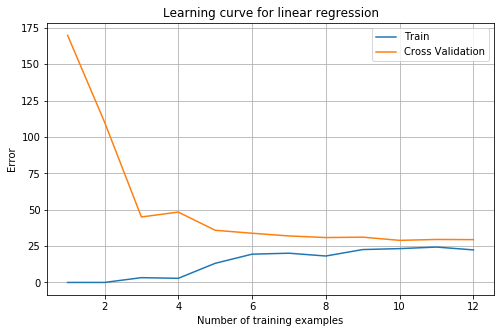

In [47]:
#both the train error and cross validation error are high when the number of training examples is increased. 
#This reflects a high bias problem in the model,
#the linear regression model is too simple and is unable to fit our dataset well.
plotLearningCurve()

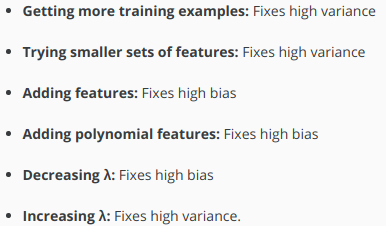

In [51]:
Image("Fixes_bias_variance1.png", width=350, height=300)

## 3. Polynomial regression

In [ ]:
#The problem with our linear model was that it was too simple for the data 
#and resulted in underfitting (high bias)
#Lets try to address this problem by adding more features

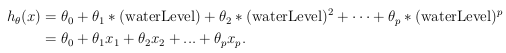

In [56]:
Image("Polynomial_hypothesis1.png", width=600, height=100)
#For polynomial regression, our hypothesis has the form

In [58]:
def genPolyFeatures(my_X,p):
    """
    Function takes in the X matrix (with bias term already included as the first column)
    and returns an X matrix with "p" additional columns.
    The first additional column will be the 2nd column (first non-bias column) squared,
    the next additional column will be the 2nd column cubed, etc.
    """
    new_X = my_X.copy()
    for i in range(p):
        dim = i+2
        new_X = np.insert(new_X,new_X.shape[1],np.power(new_X[:,1],dim),axis=1)
    return new_X

def featureNormalize(my_X):
    """
    Takes as input the X array (with bias "1" first column), does
    feature normalizing on the columns (subtract mean, divide by standard deviation).
    Returns the feature-normalized X, and feature means and stds in a list
    Note this is different than my implementation in assignment 1...
    I didn't realize you should subtract the means, THEN compute std of the
    mean-subtracted columns.
    Doesn't make a huge difference, I've found
    """
   
    X_norm = my_X.copy()
    stored_feature_means = np.mean(X_norm,axis=0) #column-by-column
    X_norm[:,1:] = X_norm[:,1:] - stored_feature_means[1:]
    stored_feature_stds = np.std(X_norm,axis=0,ddof=1)
    X_norm[:,1:] = X_norm[:,1:] / stored_feature_stds[1:]
    return X_norm, stored_feature_means, stored_feature_stds

#### Learning Polynomial Regression

In [60]:
#Generate an X matrix with terms up through x^8
#(7 additional columns to the X matrix)

###############################################################
# My d=8 plot doesn't match the homework pdf, due to differences
# between scipy.optimize.fmin_cg and the octave version
# I see that in subokita's implementation, for fitting he gets the
# same results as I when using scipy.optimize.fmin_cg
# 
# The d=5 plot (up through x^6) shows overfitting clearly, so I'll
# continue using that
###############################################################

global_d = 5
newX = genPolyFeatures(X,global_d)
newX_norm, stored_means, stored_stds = featureNormalize(newX)
#Find fit parameters starting with 1's as the initial guess
mytheta = np.ones((newX_norm.shape[1],1))
fit_theta = optimize_theta(mytheta,newX_norm,y,0.)

Optimization terminated successfully.
         Current function value: 0.198053
         Iterations: 121
         Function evaluations: 234
         Gradient evaluations: 234


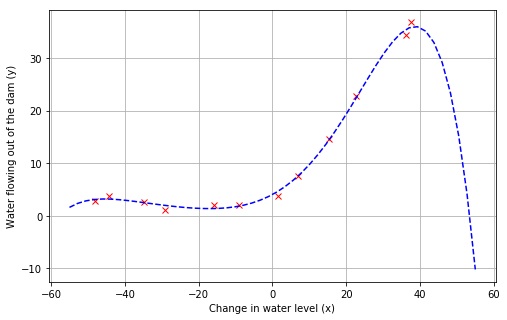

In [63]:
def plotFit(fit_theta,means,stds):
    """
    Function that takes in some learned fit values (on feature-normalized data)
    It sets x-points as a linspace, constructs an appropriate X matrix,
    un-does previous feature normalization, computes the hypothesis values,
    and plots on top of data
    """
    n_points_to_plot = 50
    xvals = np.linspace(-55,55,n_points_to_plot)
    xmat = np.ones((n_points_to_plot,1))
    
    xmat = np.insert(xmat,xmat.shape[1],xvals.T,axis=1)
    xmat = genPolyFeatures(xmat,len(fit_theta)-2)
    #This is undoing feature normalization
    xmat[:,1:] = xmat[:,1:] - means[1:]
    xmat[:,1:] = xmat[:,1:] / stds[1:]
    plot_data()
    plt.plot(xvals,hypothesis(fit_theta,xmat),'b--')

plotFit(fit_theta,stored_means,stored_stds)

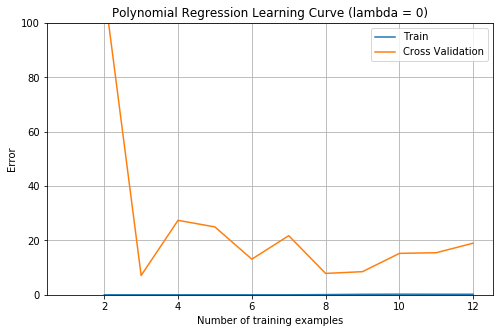

In [69]:
def plotPolyLearningCurve(my_lambda=0.):

    initial_theta = np.ones((global_d+2,1))
    mym, error_train, error_val = [], [], []
    myXval, dummy1, dummy2 = featureNormalize(genPolyFeatures(Xval,global_d))

    for x in range(1,13,1):
        train_subset = X[:x,:]
        y_subset = y[:x]
        mym.append(y_subset.shape[0])
        train_subset = genPolyFeatures(train_subset,global_d)   
        train_subset, dummy1, dummy2 = featureNormalize(train_subset)
        fit_theta = optimize_theta(initial_theta,train_subset,y_subset,my_lambda=my_lambda,print_output=False)
        error_train.append(cost_function(fit_theta,train_subset,y_subset,my_lambda=my_lambda))
        error_val.append(cost_function(fit_theta,myXval,yval,my_lambda=my_lambda))
        
    plt.figure(figsize=(8,5))
    plt.plot(mym,error_train,label='Train')
    plt.plot(mym,error_val,label='Cross Validation')
    plt.legend()
    plt.title('Polynomial Regression Learning Curve (lambda = 0)')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.ylim([0,100])
    plt.grid(True)
    
plotPolyLearningCurve()